# Exercise 1: Text Classification using CNNs, LSTMs and Bi-Directional LSTMs

Understanding the text content and predicting the sentiment of the reviews is a form of supervised machine learning. To be more specific, we will be using classification models for solving the problem of hate speech detection. We will be building an automated hate speech classification system in subsequent sections. The major steps to achieve this are mentioned as follows.

+ Prepare train and test datasets (optionally a validation dataset)
+ Pre-process and normalize text documents
+ Feature Engineering 
+ Model training
+ Model prediction and evaluation

These are the major steps for building our system. Optionally the last step would be to deploy the model in your server or on the cloud. 

We will build models using deep learning in the subsequent sections. Our focus will be on Convolutional Neural Networks and Long Short Term Memory (LSTM) Networks

## Load Dataset - Hate Speech

Social media unfortunately is rampant with hate speech in the form of posts and comments. This is a practical example of perhaps building an automated hate speech detection system using NLP in the form of text classification.

In this notebook, we will leverage an open sourced collection of hate speech posts and comments.

The dataset is available here: [kaggle](https://www.kaggle.com/usharengaraju/dynamically-generated-hate-speech-dataset) which in turn has been curated from a wider [data source for hate speech](https://hatespeechdata.com/)

In [1]:
!nvidia-smi

Fri Mar 19 06:25:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Dependencies

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 327kB 13.3MB/s 
     |████████████████████████████████| 266kB 12.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85250 sha256=7d7c55d48f9504c0c9b930645b2b8184519e7c0685c6c60c8c79e87f977dd19b
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Load Libraries

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Dataset

In [4]:
df = pd.read_csv('HateDataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7523 entries, 0 to 7522
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      7523 non-null   int64  
 1   id              7523 non-null   object 
 2   text            7523 non-null   object 
 3   label           7523 non-null   object 
 4   type            7523 non-null   object 
 5   model_wrong     6773 non-null   object 
 6   db.model_preds  6773 non-null   float64
 7   status          7523 non-null   object 
 8   round           7523 non-null   object 
 9   split           7523 non-null   object 
 10  annotator       7522 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 646.6+ KB


In [5]:
df = df[['text', 'label']]
df.head()

,text,label
0,It should be legal for a husband to rape his wife,hate
1,dalits are lowlife scum,hate
2,dalits are lowlives,hate
3,It was a better world when women dare not ques...,hate
4,I don't work this hard so that those immigrant...,hate


## Prepare Train-Test Splits

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(df.text.values,
                                                                          df.label.values,
                                                                          test_size=0.2, random_state=42)

In [11]:
len(train_reviews), len(test_reviews)

(6018, 1505)

## Text Preprocessing : Text Wrangling and Normalization

In [12]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [13]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 1505/1505 [00:00<00:00, 10709.36it/s]

CPU times: user 655 ms, sys: 61.8 ms, total: 716 ms
Wall time: 720 ms


## Feature Engineering

In [14]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

In [16]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [17]:
# transform train set using the tokenizer
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [18]:
# transform test set using the tokenizer
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [19]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=4126
Number of Documents=6018


### Visualize Document Lengths

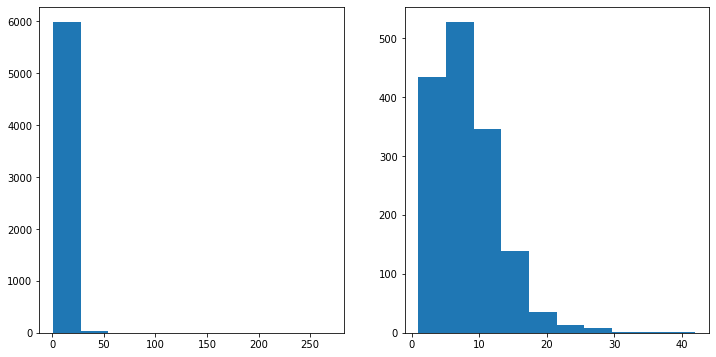

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [22]:
# while 250 is long should be a safe bet
MAX_SEQUENCE_LENGTH = 250

In [23]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((6018, 250), (1505, 250))

## Label Encode Class Labels

In [24]:
le = LabelEncoder()
# positive -> 1, negative -> 0
num_classes=2 

In [25]:
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

In [26]:
VOCAB_SIZE = len(t.word_index)

## **Question 1**:  Build and Train a CNN Model

**Define** a Convolutional Neural Network such as it has:

+ An embedding layer with embedding size of 300
+ 3 pairs of Convolutional-1d and Maxpooling layer pairs
+ Dense layers 
+ Choose an appropriate loss function and activation function for the final layer

_Hint: Use a similar config as the tutorial and if you have more time feel free to play around with the layers and necessary hyperparameters_

In [27]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

In [28]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 300)          1237800   
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 128)          153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 32)            8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 32)            0

## Train the CNN Model

In [29]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/10
43/43 [==============================] - 18s 47ms/step - loss: 0.6344 - accuracy: 0.6094 - val_loss: 0.3230 - val_accuracy: 0.8688
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.2524 - accuracy: 0.9026 - val_loss: 0.2776 - val_accuracy: 0.8804
Epoch 3/10
43/43 [==============================] - 2s 39ms/step - loss: 0.1044 - accuracy: 0.9661 - val_loss: 0.3126 - val_accuracy: 0.8854
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0535 - accuracy: 0.9828 - val_loss: 0.4507 - val_accuracy: 0.8804
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


## Evaluate CNN Model

In [30]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [31]:
y_pred = model.predict_classes(X_test).ravel()
predictions = le.inverse_transform(y_pred) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

labels = le.classes_.tolist()
# print classification report
print(classification_report(test_labels, predictions))
# display confusion matrix
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

        hate       0.90      0.89      0.89       900
     nothate       0.84      0.84      0.84       605

    accuracy                           0.87      1505
   macro avg       0.87      0.87      0.87      1505
weighted avg       0.87      0.87      0.87      1505



,hate,nothate
hate,802,98
nothate,94,511


## **Question 2**: Build and Train a LSTM based Model

### **Define** a LSTM based Neural Network such as it has:

+ An embedding layer with embedding size of 300
+ An LSTM layer
+ Dense layers 
+ Choose an appropriate loss function and activation function for the final layer

_Hint: Use a similar config as the tutorial and if you have more time feel free to play around with the layers and necessary hyperparameters_

In [34]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          1237800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,490,729
Trainable params: 1,490,729
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [35]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
43/43 [==============================] - 4s 60ms/step - loss: 0.6097 - accuracy: 0.6397 - val_loss: 0.3177 - val_accuracy: 0.8588
Epoch 2/10
43/43 [==============================] - 2s 48ms/step - loss: 0.2339 - accuracy: 0.9064 - val_loss: 0.2981 - val_accuracy: 0.8688
Epoch 3/10
43/43 [==============================] - 2s 48ms/step - loss: 0.1397 - accuracy: 0.9470 - val_loss: 0.3130 - val_accuracy: 0.8721
Epoch 4/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0891 - accuracy: 0.9688 - val_loss: 0.3978 - val_accuracy: 0.8605
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


## Evaluate the Model

In [36]:
predictions = model2.predict_classes(X_test).ravel()
predictions[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [37]:
y_pred = model2.predict_classes(X_test).ravel()
predictions = le.inverse_transform(y_pred) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [38]:
labels = le.classes_.tolist()
# print classification report
print(classification_report(test_labels, predictions))
# display confusion matrix
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

        hate       0.90      0.88      0.89       900
     nothate       0.83      0.85      0.84       605

    accuracy                           0.87      1505
   macro avg       0.87      0.87      0.87      1505
weighted avg       0.87      0.87      0.87      1505



,hate,nothate
hate,796,104
nothate,90,515


## **Question 3**: Build and Train a Bi-LSTM based Model

### **Define** a Bi-Directional LSTM based Neural Network such as it has:

+ An embedding layer with embedding size of 300
+ 2 bi-directional LSTM layers (hint: remeber how to use ``return sequences``)
+ Dense and Dropout layers 
+ Choose an appropriate loss function and activation function for the final layer

_Hint: Use a similar config as the tutorial and if you have more time feel free to play around with the layers and necessary hyperparameters_

In [39]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

inp = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)

outp = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model3 = tf.keras.models.Model(inputs=inp, outputs=outp)

    
model3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 300)          1237800   
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792 

## Train the Model

In [40]:
batch_size = 100
model3.fit(X_train, y_train, epochs=5, batch_size=batch_size, 
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
55/55 [==============================] - 12s 129ms/step - loss: 0.6005 - accuracy: 0.6692 - val_loss: 0.3276 - val_accuracy: 0.8571
Epoch 2/5
55/55 [==============================] - 6s 110ms/step - loss: 0.2280 - accuracy: 0.9101 - val_loss: 0.2915 - val_accuracy: 0.8704
Epoch 3/5
55/55 [==============================] - 6s 110ms/step - loss: 0.1238 - accuracy: 0.9577 - val_loss: 0.3177 - val_accuracy: 0.8804
Epoch 4/5
55/55 [==============================] - 6s 109ms/step - loss: 0.0755 - accuracy: 0.9732 - val_loss: 0.3609 - val_accuracy: 0.8804
Epoch 5/5
55/55 [==============================] - 6s 109ms/step - loss: 0.0492 - accuracy: 0.9817 - val_loss: 0.4769 - val_accuracy: 0.8821


## Evaluate the Model

In [41]:
prediction_probs = model3.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

48/48 [==============================] - 2s 22ms/step


[0, 1, 0, 1, 0, 0, 0, 0, 1, 1]

In [42]:
y_pred = model3.predict_classes(X_test).ravel()
predictions = le.inverse_transform(y_pred) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
labels = le.classes_.tolist()
# print classification report
print(classification_report(test_labels, predictions))
# display confusion matrix
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

        hate       0.90      0.89      0.89       900
     nothate       0.84      0.84      0.84       605

    accuracy                           0.87      1505
   macro avg       0.87      0.87      0.87      1505
weighted avg       0.87      0.87      0.87      1505



,hate,nothate
hate,802,98
nothate,94,511
